In [1]:
# package imports
import numpy as np
import operator
import argparse

# plot-specific imports
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

# user-defined imports
import utils
from utils_plot import Args
import utils_plot as putils

# USER: CHANGE THESE VARIABLES

In [2]:
args = Args() # create an argument class

args.DATASET = 'xray' # 'mnist', 'xray', or 'retino' 
args.DEMO = 'True' # If 'True' run over 5 images for demo; else run over entire dataset
# args.NUM_MEASUREMENTS_LIST = [10,25,35,50,75,100,200] # mnist
args.NUM_MEASUREMENTS_LIST = [500,1000,2000,4000,8000] # xray or retino

args.ALG_LIST = ['csdip','bm3d','tval3','dct'] # choose which algorithms to plot

args = putils.construct_arg(args)

In [3]:
dataloader = utils.get_data(args) # get original images in PyTorch object

# load reconstructions, compute mse
RECONSTRUCTIONS, MSE = putils.get_plot_data(dataloader, args)

# PLOT MSE VALUES

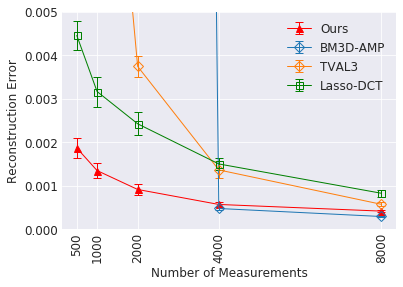

In [4]:
sns.set_style('darkgrid')
matplotlib.rc('font', size=12)
KWARGS_DICT = putils.set_kwargs()

# Plot MSE of each algorithm
for ALG in args.ALG_LIST:
    kwargs = KWARGS_DICT[ALG]
    putils.plot_mse(MSE[ALG], args, kwargs)

Y_LIM = 0.005 # set max value on vertical axis 
putils.plot_format(Y_LIM, args) # set labels, limits, ticks, legend in plot

plt.show()

# PLOT RECONSTRUCTIONS

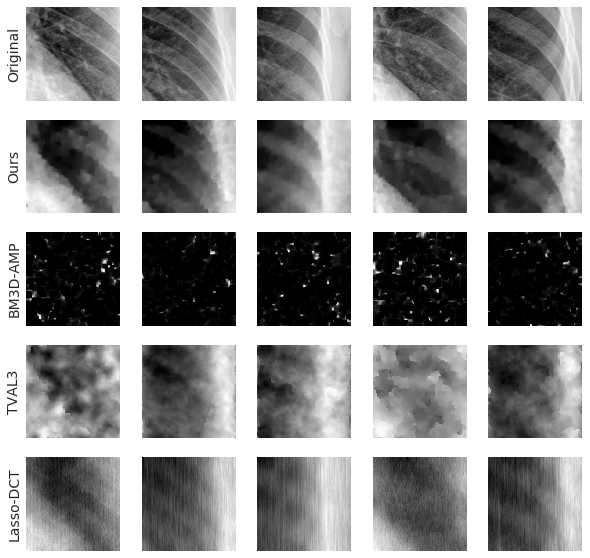

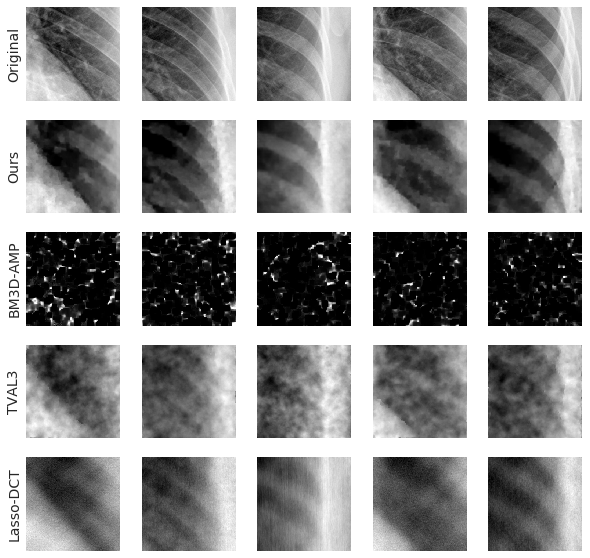

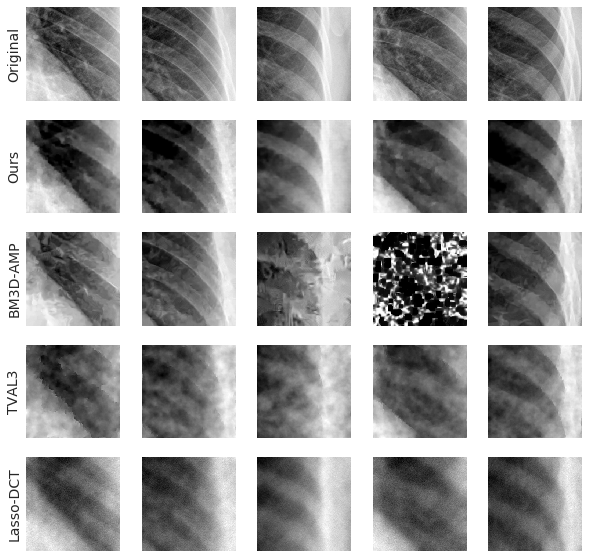

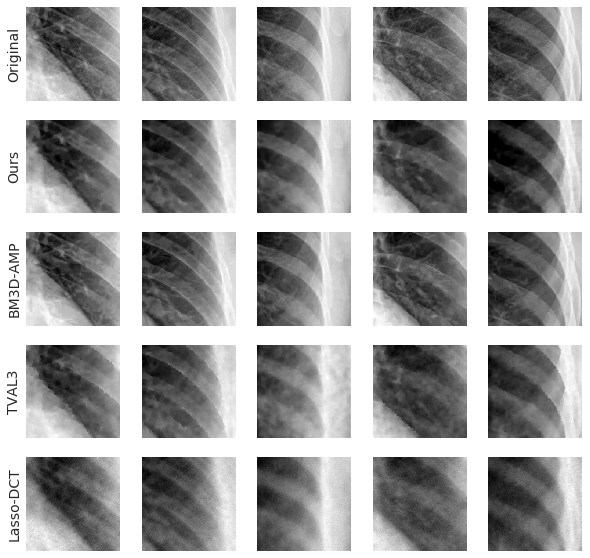

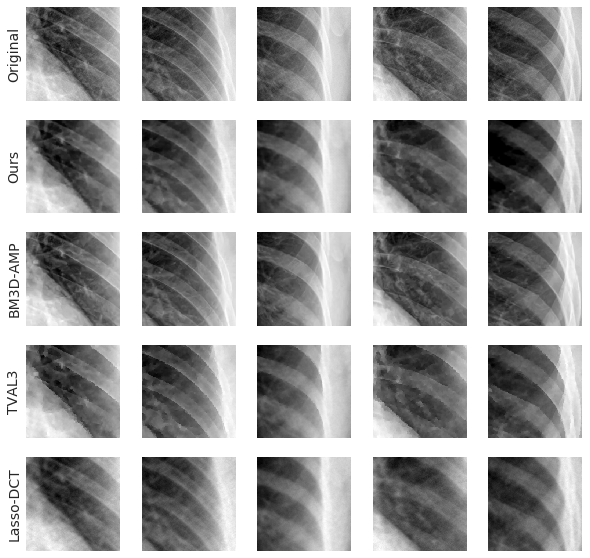

In [5]:
FIG_HEIGHT = 5
NUM_PLOT = 5

for NUM_MEASUREMENTS in args.NUM_MEASUREMENTS_LIST:
    fig = plt.figure(figsize=[2* NUM_PLOT, 2* FIG_HEIGHT])
    outer_counter = 0
    inner_counter = 0

    # Diplay original images
    outer_counter += 1
    for k, (batch, _ , im_path) in enumerate(dataloader):
        if k not in range(NUM_PLOT):
            continue
        inner_counter += 1

        ax = fig.add_subplot(FIG_HEIGHT, 1, outer_counter, frameon=False)
        putils.set_axes('Original', ax)  
        _ = fig.add_subplot(FIG_HEIGHT, NUM_PLOT, inner_counter)
        putils.plot_image(batch, args, flag='orig')
    
    # Display reconstructions
    for i,ALG in enumerate(args.ALG_LIST):
        args.ALG = ALG
        outer_counter += 1
        for k, image in enumerate(RECONSTRUCTIONS[ALG][NUM_MEASUREMENTS]):
            if k not in range(NUM_PLOT):
                continue
            inner_counter += 1
            
            ax = fig.add_subplot(FIG_HEIGHT, 1, outer_counter, frameon=False)
            putils.set_axes(KWARGS_DICT[ALG]['label'], ax)
            _ = fig.add_subplot(FIG_HEIGHT, NUM_PLOT, inner_counter)
            putils.plot_image(image, args, flag='recons')